In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# OS Features
import os

# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Processing results
import json

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Modeling
from sklearn.linear_model import LinearRegression

# Preprocessing - Data standardization
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [4]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "203",
    "Plant": "M",
    "Features": "Chemical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [267]:
df = pd.read_csv("../../../../../data/processed/203/m.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we use all available features

In [268]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "Blaine",
        "#200",
        "#325",
        "Final setting time",
        "Initial setting time",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

# 1. Linear Regression

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [269]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 59 samples each
    2. 90% train (535 samples each fold)
    3. 10% test (59 samples each fold)
<b>Total:</b> 100 models<br>

In [270]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -4.927 (0.032)
MAE: -3.848 (0.028)
MAPE: -0.084 (0.001)
R2: 0.629 (0.005)


******
[TEST]
******
RMSE: -4.940 (0.127)
MAE: -3.855 (0.095)
MAPE: -0.085 (0.002)
R2: 0.626 (0.018)




<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 118 samples
    2. 50% train (59 samples each fold)
    3. 50% test (59 samples each fold)
<b>Total:</b> 5 models<br>

In [271]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -3.945 (0.265)
MAE: -2.999 (0.181)
MAPE: -0.065 (0.004)
R2: 0.736 (0.098)


******
[TEST]
******
RMSE: -4.662 (1.347)
MAE: -3.525 (0.925)
MAPE: -0.080 (0.023)
R2: 0.561 (0.291)




<IPython.core.display.Javascript object>

In [272]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [273]:
for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [274]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,1900-01-24 01:26:24,54.8,54.347106,TRAIN,CP II-E40
1,2011-05-09 00:00:00,40.4,43.310561,TRAIN,CP II-F32
2,2011-05-10 00:00:00,41.2,43.745604,TRAIN,CP II-F32
3,2011-05-11 00:00:00,53.3,52.939967,TRAIN,CP VARI
4,2011-05-12 00:00:00,40.8,44.885842,TRAIN,CP II-F32
...,...,...,...,...,...
6140,2023-03-22 00:00:00,54.0,55.892379,TEST,CP VARI
6141,2023-03-22 00:00:00,50.1,51.276801,TEST,CP II-E40
6142,2023-03-23 00:00:00,35.5,38.274859,TEST,CP III32
6143,2023-03-23 00:00:00,41.6,38.726067,TEST,CP II-E32


<IPython.core.display.Javascript object>

In [275]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6145 entries, 0 to 6144
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE         6145 non-null   datetime64[ns]
 1   CS28         6145 non-null   float64       
 2   CS28_PRED    6145 non-null   float64       
 3   SET          6145 non-null   object        
 4   CEMENT_TYPE  6145 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 288.0+ KB


<IPython.core.display.Javascript object>

In [276]:
df_pred.to_excel("fab_203_plant_M.xlsx", index=False)

<IPython.core.display.Javascript object>

In [277]:
df_filter = df_pred[df_pred["SET"] == "TEST"]
r2_score(df_filter["CS28"], df_filter["CS28_PRED"])

0.6433738951089732

<IPython.core.display.Javascript object>

In [278]:
preds = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    preds.append(df_pred.loc[index_test].copy())

<IPython.core.display.Javascript object>

In [279]:
scrs = []
for df_filter in preds:
    r = r2_score(df_filter["CS28"], df_filter["CS28_PRED"])
    scrs.append(r)

<IPython.core.display.Javascript object>

In [280]:
np.mean(scrs)

0.5613519611775976

<IPython.core.display.Javascript object>

In [281]:
for r in scrs:
    print(r)

0.20652727566407048
0.8158575617979342
0.21773827126381728
0.697498030000447
0.8691386671617185


<IPython.core.display.Javascript object>

In [282]:
df_copy2 = df.copy()

<IPython.core.display.Javascript object>

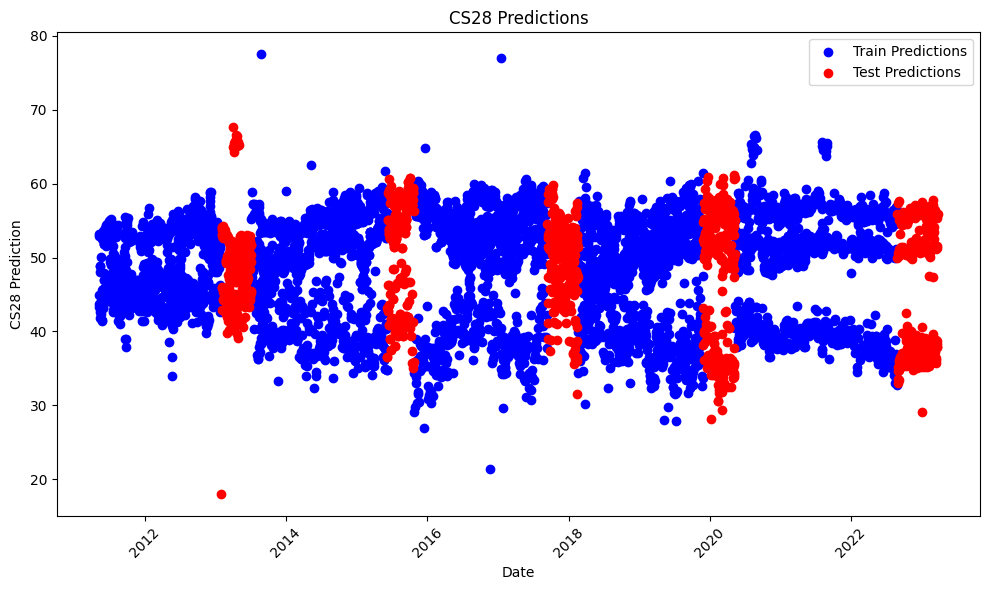

<IPython.core.display.Javascript object>

In [283]:
import pandas as pd
import matplotlib.pyplot as plt


df = df_pred.drop(["CEMENT_TYPE"], axis=1).iloc[1:].reset_index(drop=True).copy()

# Convert 'DATE' column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Separate train and test sets
train_data = df[df['SET'] == 'TRAIN']
test_data = df[df['SET'] == 'TEST']

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(train_data['DATE'], train_data['CS28_PRED'], color='blue', label='Train Predictions')
plt.scatter(test_data['DATE'], test_data['CS28_PRED'], color='red', label='Test Predictions')

# plt.scatter(df['DATE'], df['CS28'], color='green', label='Actual')

plt.xlabel('Date')
plt.ylabel('CS28 Prediction')
plt.title('CS28 Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


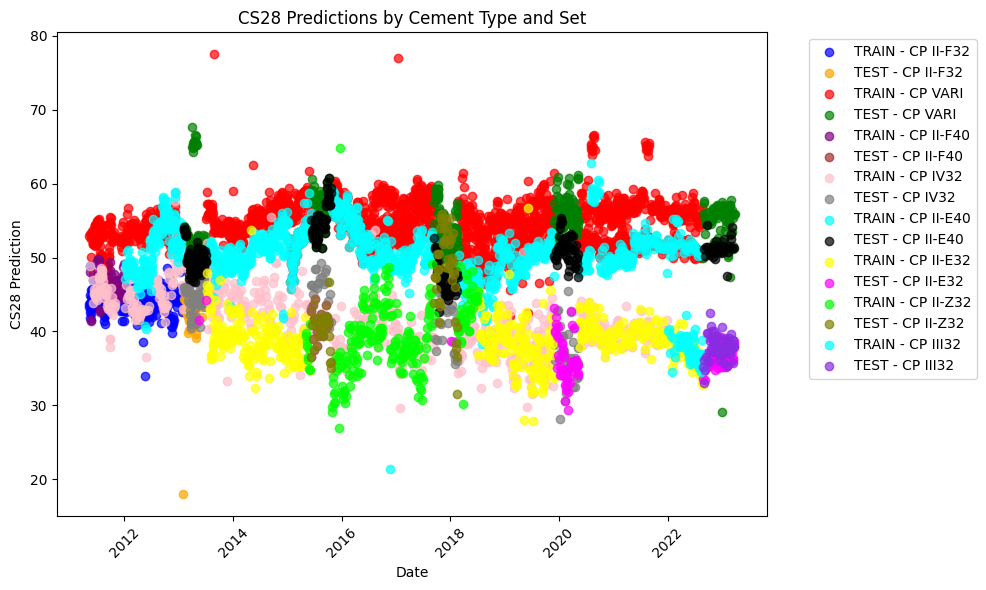

<IPython.core.display.Javascript object>

In [287]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have your DataFrame df
df = df_pred.iloc[1:].reset_index(drop=True).copy()

# Get unique cement types
cement_types = ['CP II-F32', 'CP VARI', 'CP II-F40', 'CP IV32', 'CP II-E40', 'CP II-E32', 'CP II-Z32', 'CP III32']

# Define colors for train and test sets for each cement type
cement_colors = {
    'CP II-F32': {'TRAIN': 'blue', 'TEST': 'orange'},
    'CP VARI': {'TRAIN': 'red', 'TEST': 'green'},
    'CP II-F40': {'TRAIN': 'purple', 'TEST': 'brown'},
    'CP IV32': {'TRAIN': 'pink', 'TEST': 'gray'},
    'CP II-E40': {'TRAIN': 'cyan', 'TEST': 'black'},
    'CP II-E32': {'TRAIN': 'yellow', 'TEST': 'magenta'},
    'CP II-Z32': {'TRAIN': 'lime', 'TEST': 'olive'},
    'CP III32': {'TRAIN': 'cyan', 'TEST': 'blueviolet'}
}

# Plotting
plt.figure(figsize=(10, 6))

# Plotting predictions for each cement type and set type
for cement_type in cement_types:
    for set_type in ['TRAIN', 'TEST']:
        set_cement_data = df[(df['CEMENT_TYPE'] == cement_type) & (df['SET'] == set_type)]
        plt.scatter(set_cement_data['DATE'], set_cement_data['CS28_PRED'], label=f'{set_type} - {cement_type}', color=cement_colors[cement_type][set_type], alpha=0.7)

plt.xlabel('Date')
plt.ylabel('CS28 Prediction')
plt.title('CS28 Predictions by Cement Type and Set')
plt.xticks(rotation=45)

# Place legend outside the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [240]:
df["CEMENT_TYPE"].unique()

array(['CP II-F32', 'CP VARI', 'CP II-F40', 'CP IV32', 'CP II-E40',
       'CP II-E32', 'CP II-Z32', 'CP III32'], dtype=object)

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (594, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 54, 108, 162, 216, 270, 324, 378, 432, 486 samples each fold
    2. Test: 54 samples each fold
<b>Total:</b> 10 models<br>

In [10]:
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -4.692 (0.342)
MAE: -3.659 (0.276)
MAPE: -0.079 (0.007)
R2: 0.582 (0.026)


******
[TEST]
******
RMSE: -6.355 (1.656)
MAE: -4.326 (0.799)
MAPE: -0.096 (0.017)
R2: 0.326 (0.411)




<IPython.core.display.Javascript object>

## 1.4. Out of time Split Cross Validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Train size: 80%</b><br>
<b>Test  size: 20%</b>


<b>Splits:</b> 2<br>    
    1. Train: 475
    2. Test: 118
<b>Total:</b> 1 model<br>

In [11]:
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=SEED, shuffle=False
)
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)

pipeline.fit(x_train, y_train)

y_train_pred = pipeline.predict(x_train)
y_test_pred = pipeline.predict(x_test)

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Out of time Split"
results_dict_copy["Cross Validation Params"] = '{"Test Size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(
    results_dict_copy, {key: [value] for key, value in scores.items()}
)
results_to_save.append(df_results)

******
[TRAIN]
******
RMSE: 4.863 (0.000)
MAE: 3.819 (0.000)
MAPE: 0.084 (0.000)
R2: 0.621 (0.000)


******
[TEST]
******
RMSE: 6.853 (0.000)
MAE: 4.691 (0.000)
MAPE: 0.106 (0.000)
R2: 0.391 (0.000)




<IPython.core.display.Javascript object>

In [12]:
pd.concat(results_to_save).groupby(
    ["Features", "Model", "Cross Validation", "Cross Validation Params"]
)[["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features              Model            Cross Validation  \
                                                             
0  Chemical  Linear Regression  Blocking Time Series Split   
1  Chemical  Linear Regression           Out of time Split   
2  Chemical  Linear Regression              Repeated KFold   
3  Chemical  Linear Regression           Time Series Split   

                            Cross Validation Params RMSE Test            \
                                                         mean       std   
0  {"N_Splits": 5, "Repeats": 1, "train_size": 0.8}  4.661530  1.346892   
1                                {"Test Size": 0.2}  6.853308  0.000000   
2                     {"N_Splits": 5, "Repeats": 3}  4.940453  0.126762   
3           {"N_Splits": 5, "Repeats": 1, "Gap": 0}  6.355011  1.656071   

   MAE Test           MAPE Test             R2 Test            
       mean       std      mean       std      mean       std  
0  3.525004  0.924943  0.080317  0.022893  0.561352  0.290521  
1  4.690644  0.000000  0.106392  0.000000  0.391130  0.000000  
2  3.854596  0.094855  0.084603  0.002247  0.626285  0.018057  
3  4.326490  0.799164  0.095684  0.016829  0.325513  0.411436

<IPython.core.display.Javascript object>

# Saving the results Dataframe

In [13]:
index_to_save = 2

<IPython.core.display.Javascript object>

In [14]:
path = "../../../../../reports/results/local_models/203/m/full/"
filename = f"linear_regression_results_full_{index_to_save}.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

## Saving the grouped dataframe

In [15]:
cols_groupby = [
    "Category",
    "Company",
    "Data Shape",
    "Timesteps",
    "Features",
    "Model",
    "Cross Validation",
    "Cross Validation Params",
]

cols_agg = ["RMSE Train", "MAE Train", "MAPE Train", "R2 Train"] + [
    "RMSE Test",
    "MAE Test",
    "MAPE Test",
    "R2 Test",
]

path = "../../../../../reports/results/local_models/203/m/grouped/"
filename = f"linear_regression_results_grouped_{index_to_save}.csv"


df_results_to_save = (
    pd.concat(results_to_save)
    .groupby(cols_groupby, dropna=False)[cols_agg]
    .agg(["mean", lambda series: pd.Series(series.std(ddof=0), name="std")])
    .reset_index()
    .rename(columns={"<lambda_0>": "std"})
)

df_results_to_save.to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

In [16]:
pd.Series(
    pipeline.named_steps["estimator"].coef_,
    df_copy.drop(["Date"], axis=1).columns,
).to_frame(name="Coefficients").sort_values(
    by="Coefficients"
).style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,Coefficients
Loss on Ignition,-3.272216
K2O,-3.220438
MgO,-1.298448
Na2O,-0.116943
SO3,1.690048


<IPython.core.display.Javascript object>